In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory
from mpl_toolkits.mplot3d import Axes3D

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor


def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        original_noise=True,
        action_clipper=[-10., 10.],
        tau_clipper=[0.001, 1.],
        params_logging=False,
        gradient_logging=False,
        batch_size=128,
    )
    return agent

In [4]:
# agent compilation
l = 1.
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)

In [5]:
def value_function_ap(state, agent):
    # Q(s,a)
    assert agent.compiled == True
    state_ = np.array([[state]])
    action_ = agent.actor.predict(state_)
    value_function = agent.critic.predict([action_, state_])[0][0] #Q(a,s)
    return value_function

def value_function(state, agent, step_limit=5000):
    # accumulated reward
    gamma = 0.99
    env.reset()
    env.set_state = state
    episode_reward = 0
    for steps in range(step_limit):
        reward = 0
        x = env.state
        a_agent, tau = agent.forward(x)
        action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.05
        dt = tau / action_repetition
        for p in range(action_repetition):
            _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
            reward += r
        reward *= dt
        reward += - tau * 0.01 * a_agent**2 + l * tau # step reward

        episode_reward += pow(gamma, steps) * reward
    return episode_reward

def value_for_one_state(action, agent, state=np.array([0., 0.])):
    # Q(const, a)
    assert agent.compiled == True
    state_ = np.array([[state]])
    action_ = np.array([action])
    value_function = agent.critic.predict([action_, state_])[0][0] #Q(a,s)
    return value_function

def learned_Q(state, action, agent, env):
    # r(s,a) + gamma*V(s')
    env.reset()
    env.set_state(state)
    
    reward = 0
    gamma = 0.99
    a_agent, tau = action
    action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.05
    dt = tau / action_repetition
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=0) # ノイズを加えないでシミュレーションしたのが期待値？？
        reward += r
    reward *= dt
    reward += - tau * 0.01 * a_agent**2 + l * tau # step reward
    
    next_state = env.state
    next_value = value_function_ap(next_state, agent) # 学習できていないstateに行った時は間違ったvalueになるはず
    
    return reward + gamma * next_value

def learned_Q_noisy(state, action, agent, env, n_expectation_samples=10):
    # r(s,a) + gamma*V(s')
    
    l = 1.
    average_reward = 0
    average_value = 0
    gamma = 0.99
    a_agent, tau = action
    action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.05
    dt = tau / action_repetition
    for i in range(n_expectation_samples):
        reward = 0
        env.reset()
        env.set_state(state)
        for p in range(action_repetition):
            _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
            reward += r
        reward *= dt
        reward += - tau * 0.01 * a_agent**2 + l * tau # step reward
        average_reward += reward / n_expectation_samples
    
        next_state = env.state
        next_value = value_function_ap(next_state, agent) # 学習できていないstateに行った時は間違ったvalueになるはず
        average_value += next_value / n_expectation_samples
    
    return average_reward + gamma * average_value

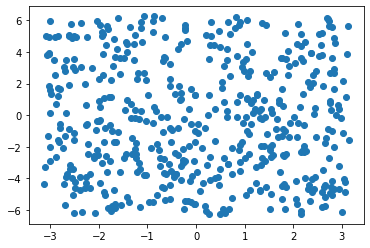

In [11]:
# sample_state
with open('./csv/state_batch.csv', 'r') as f:
    reader = csv.reader(f)
    state_batch = np.array([row for row in reader]).astype('float')
plt.scatter(state_batch[:,0], state_batch[:,1])

## いい感じagentに対するcriticの近似精度

In [42]:
a.load_weights('./saved_agent/learned_self_clipped3.h5')

In [43]:
with open('./csv/v_aps3.csv', 'r') as f:
    reader = csv.reader(f)
    v_aps = np.array([r for r in reader]).astype('float')[0]

with open('./csv/vs3.csv', 'r') as f:
    reader = csv.reader(f)
    vs = np.array([r for r in reader]).astype('float')[0]

In [9]:
# initital ciritic
# 初期criticからちゃんと学習進んでる？？

initial_critic = critic_net((2,),(2,))[0]
v_inits = []

for i, state in enumerate(state_batch):
    print(f'{int(i/5)}%\r',end='')
    state_ = np.array([[state]])
    action_ = a.actor.predict(state_)
    vf = initial_critic.predict([action_, state_])[0][0] #Q(a,s)
    v_inits.append(vf)

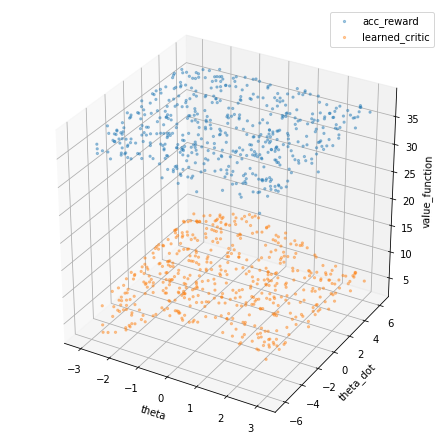

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('value_function')

ax.scatter3D(state_batch[:,0], state_batch[:,1], vs, marker='.', alpha=0.4, label='acc_reward')
ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps, marker='.', alpha=0.4, label='RL_critic')
# ax.scatter3D(state_batch[:,0], state_batch[:,1], v_inits, marker='.', alpha=0.4, label='initial_critic')
plt.legend()

## 比較: 0.01サンプル値agentに対するcriticの近似

In [11]:
a.load_weights('./saved_agent/learned_from_001.h5')

In [12]:
with open('./csv/v_aps_001.csv', 'r') as f:
    reader = csv.reader(f)
    v_aps_001 = np.array([r for r in reader]).astype('float')[0]

with open('./csv/vs_001.csv', 'r') as f:
    reader = csv.reader(f)
    vs_001 = np.array([r for r in reader]).astype('float')[0]

In [21]:
# initital ciritic
# 初期criticからちゃんと学習進んでる？？

initial_critic = critic_net((2,),(2,))[0]
v_inits_001 = []

for i, state in enumerate(state_batch):
    print(f'{int(i/5)}%\r',end='')
    state_ = np.array([[state]])
    action_ = a.actor.predict(state_)
    vf = initial_critic.predict([action_, state_])[0][0] #Q(a,s)
    v_inits_001.append(vf)

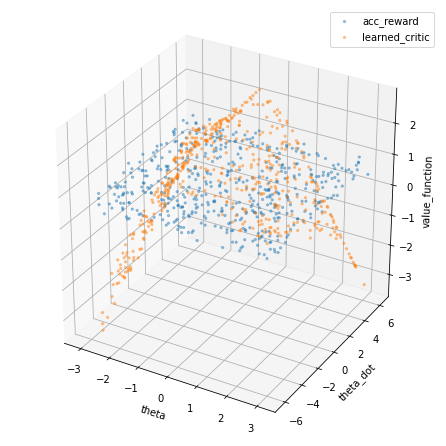

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('value_function')

ax.scatter3D(state_batch[:,0], state_batch[:,1], vs_001, marker='.', alpha=0.4, label='acc_reward')
ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps_001, marker='.', alpha=0.4, label='critic')
# ax.scatter3D(state_batch[:,0], state_batch[:,1], v_inits_001, marker='.', alpha=0.4, label='initial_critic')
plt.legend()

## $Q(s, \pi(s)) - \{(r(s, \pi(s)) + \gamma Q(s^{\prime}, \pi(s^{\prime}))\}$を計算してみる

In [ ]:
# もう一度いい感じagentで
a.load_weights('./saved_agent/learned_self4.h5')

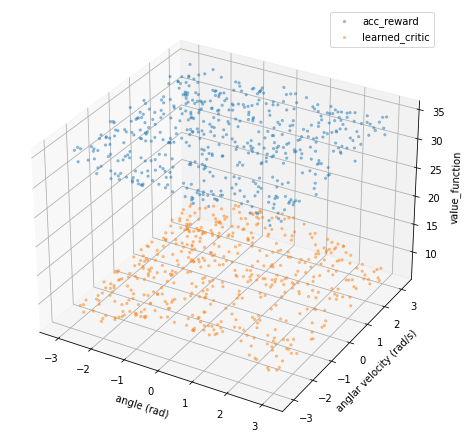

In [70]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('angle (rad)')
ax.set_ylabel('anglar velocity (rad/s)')
ax.set_zlabel('value_function')

ax.scatter3D(state_batch[:,0], state_batch[:,1], vs, marker='.', alpha=0.4, label='acc_reward')
ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps, marker='.', alpha=0.4, label='RL_critic')
plt.legend()

In [58]:
def TD_error(state0, state1, agent):
    gamma = 0.99
    reward = 0
    
    # left hand side
    left = value_function_ap(state0, agent)
    
    # caluculate reward r(s, π(s))
    env.reset()
    env.set_state(state0)
    a_agent, tau = agent.forward(state0)
    action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.05
    dt = tau / action_repetition
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - tau * 0.01 * a_agent**2 + l * tau # step reward
    
    # right hand side
    right = reward + gamma * value_function_ap(state1, agent)
    return left - right

In [34]:
with open('./csv/replay_buffer.csv', 'r') as f:
    reader = csv.reader(f)
    replay_buffer = np.array([r for r in reader]).astype('float')

In [61]:
batch_size = 128
idxs = np.random.choice(np.array(range(len(replay_buffer))), batch_size, replace=False)

states = replay_buffer[idxs]

tds = []
for i in range(len(states)-1):
    tds.append(TD_error(states[i], states[i+1], a)**2)

print(np.average(tds))

0.13392293556399043


In [69]:
# process_noiseが乗っていないので、安定化が実現してからのtauの変化を学習することができなくなっている

## 方策固定して教師あり学習したcriticをみてみる
supervised_dist は 一番(s,a)の分散がでかい<br>
supervised2 は $\tau, u$の両方にノイズを載せた<br>
supervised は $(s, \pi(s))$で学習<br>

In [12]:
# load agent
a.actor.load_weights('./saved_agent/learned_self_noisy_actor.h5')
a.critic.load_weights('./saved_agent/learned_self_noisy_critic_supervised.h5')

In [14]:
vs = []

for state in state_batch:
    vs.append(value_function(state, a))

vs = np.array(vs)

In [20]:
with open('./csv/vs_noisy.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(vs)

In [13]:
a.critic.load_weights('./saved_agent/learned_self_noisy_critic.h5')
v_aps = []

for state in state_batch:
    v_aps.append(value_function_ap(state, a))
    
v_aps = np.array(v_aps)


a.critic.load_weights('./saved_agent/learned_self_noisy_critic_supervised.h5')
v_aps2 = []

for state in state_batch:
    v_aps2.append(value_function_ap(state, a))
    
v_aps2 = np.array(v_aps2)

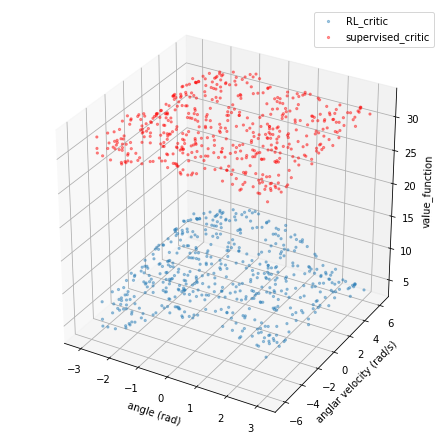

In [17]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib notebook

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('angle (rad)')
ax.set_ylabel('anglar velocity (rad/s)')
ax.set_zlabel('value_function')

#ax.scatter3D(state_batch[:,0], state_batch[:,1], vs, marker='.', alpha=0.4, label='acc_reward')
ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps, marker='.', alpha=0.4, label='RL_critic')
ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps2, marker='.', alpha=0.4, label='supervised_critic', color='red')
plt.legend()
plt.show()

In [78]:
# load agent
a.actor.load_weights('./saved_agent/learned_self_clipped3_actor.h5')
a.critic.load_weights('./saved_agent/learned_self_clipped3_critic_supervise.h5')

In [79]:
v_aps2 = []
    
for state in state_batch:
    v_aps2.append(value_function_ap(state, a))
    
v_aps2 = np.array(v_aps2)

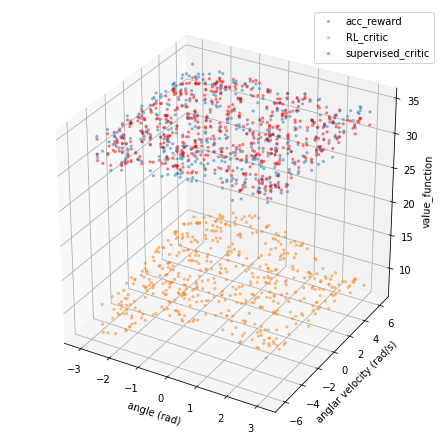

In [80]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib notebook

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('angle (rad)')
ax.set_ylabel('anglar velocity (rad/s)')
ax.set_zlabel('value_function')

ax.scatter3D(state_batch[:,0], state_batch[:,1], vs, marker='.', alpha=0.4, label='acc_reward')
ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps, marker='.', alpha=0.4, label='RL_critic')
ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps2, marker='.', alpha=0.4, label='supervised_critic', color='red')
plt.legend()
plt.show()

In [89]:
# load agent
a.actor.load_weights('./saved_agent/learned_self_clipped4_actor.h5')
a.critic.load_weights('./saved_agent/learned_self_clipped4_critic.h5')

In [90]:
v_aps2 = []
    
for state in state_batch:
    v_aps2.append(value_function_ap(state, a))
    
v_aps2 = np.array(v_aps2)

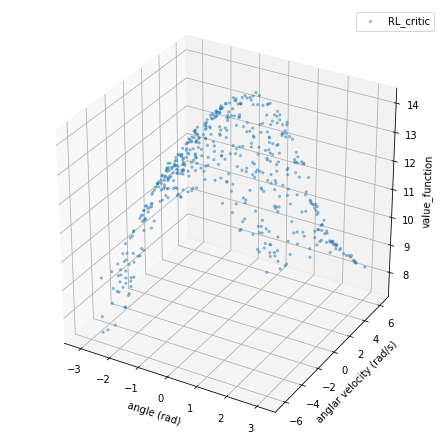

In [91]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib notebook

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('angle (rad)')
ax.set_ylabel('anglar velocity (rad/s)')
ax.set_zlabel('value_function')

ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps, marker='.', alpha=0.4, label='RL_critic')
plt.legend()
plt.show()

# s固定時のQ関数のaに関する微分は？
$f_{const}(a) = Q(const, a)$

In [55]:
high = np.array([10., 1.])
low = np.array([-10., 0.01])

action_batch = []
for i in range(500):
    action_batch.append(np.random.uniform(low=low, high=high))
    
action_batch = np.array(action_batch)

In [66]:
const_state_Q = []
const_state_Q_supervised = []

const_state = np.array([0, 0])

a.critic.load_weights('./saved_agent/learned_self_clipped2_critic.h5')
for action in action_batch:
    const_state_Q.append(value_for_one_state(action, a, const_state))

a.critic.load_weights('./saved_agent/learned_self_clipped2_critic_supervised.h5')
for action in action_batch:
    const_state_Q_supervised.append(value_for_one_state(action, a, const_state))

const_state_Q, const_state_Q_supervised = np.array(const_state_Q), np.array(const_state_Q_supervised)

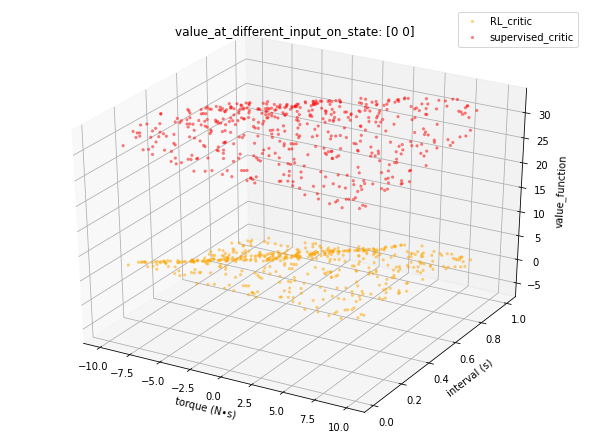

In [69]:
%matplotlib inline
# %matplotlib notebook

fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig)
ax.set_xlabel('torque (N•s)')
ax.set_ylabel('interval (s)')
ax.set_zlabel('value_function')

ax.scatter3D(action_batch[:,0], action_batch[:,1], const_state_Q, marker='.', alpha=0.4, label='RL_critic', color='orange')
ax.scatter3D(action_batch[:,0], action_batch[:,1], const_state_Q_supervised, marker='.', alpha=0.4, label='supervised_critic', color='red')
ax.set_title(f'value_at_different_input_on_state: {const_state}')
plt.legend()

In [ ]:
#これのvaluefunctionで計算したQ関数版

### ↑関数としての値は全然違うけど、関数の形は似ている！(=微分は似た値が出てくる！) (拡大したらちゃんとなってる)
・だからと言ってcriticの近似精度が悪いことは変わりない事実
・関数の形の意味のわかる形なので、蓄積rewardの方が間違っている可能性が高い

# 正しいQ関数を求める
## $Q(s,a) = r(s,a) + \gamma V(s^{\prime})$

In [102]:
a.actor.load_weights('./saved_agent/learned_self_clipped4_actor.h5')

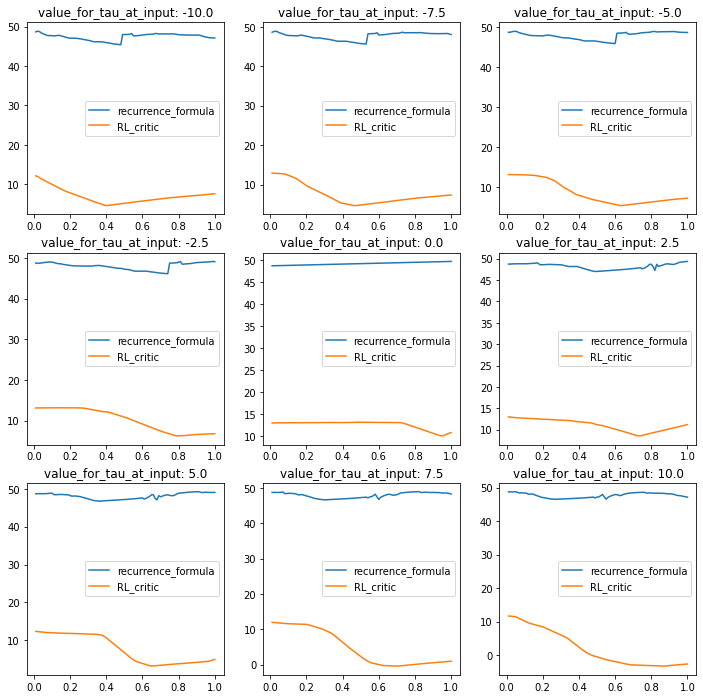

In [103]:
%matplotlib inline
taus = np.linspace(0.01,1.0,100)
inputs = np.linspace(-10, 10, 9)
state = np.array([.0,.0])

plt.figure(figsize=(12,12))
for i, inp in enumerate(inputs):
    plt.subplot(3,3,i+1)
    fq = []
    #fs = []
    fl = []
    for tau in taus:
        action = np.array([inp, tau])
        a.critic.load_weights('./saved_agent/learned_self_clipped4_critic_supervised.h5') # value function計算用
        fq.append(learned_Q(state, action, a, env))
        a.critic.load_weights('./saved_agent/learned_self_clipped4_critic.h5')
        fl.append(value_for_one_state(action, a, state=state))
    plt.plot(taus, fq, label='recurrence_formula')
    plt.plot(taus, fl, label='RL_critic')
    plt.title(f'value_for_tau_at_input: {inp}')
    plt.legend()
plt.show()

## 3つの教師データに対する学習結果の比較
supervised : $V(s)$を一番よく近似できる$Q(s,a)$を近似できた($(s,\pi(s))$の組みに対してだけのoverfit) <br>
supervised2 : $Q(s,a)$が入力信号が$\pi(s)$に近いところのみ, $\tau$の変化を正しく表現できた. <br>
supervised_dist : $V(s)$を最も近似できなかったが, $Q(s,a)$は満遍なく学習できた. ただ, 値が違うのがよくわからない.

探索と活用のジレンマを、最も効率をあげたい<br>
後ろのホワイトボードに案を書いている

## $f_{const}(a) = Q(const,a)$を, 正しいQ関数で

In [7]:
action = np.arange(-10., 10., 0.2)            # x軸を作成
tau = np.arange(0.01, 1., 0.0099)            # y軸を作成
A, T = np.meshgrid(action, tau)             # x軸とy軸からグリッドデータを作成

const_state_Q = []
const_state_Q_supervised = []
comparison = []
const_state_Q_recurrence = []

const_state = np.array([0.0, 0.0])

a.critic.load_weights('./saved_agent/learned_self_noisy_critic.h5')
for ac, t in zip(A.flatten(), T.flatten()):
    action = np.array([ac, t])
    const_state_Q.append(value_for_one_state(action, a, const_state))

a.critic.load_weights('./saved_agent/learned_self_noisy_critic_supervised_dist.h5')
for ac, t in zip(A.flatten(), T.flatten()):
    action = np.array([ac, t])
    const_state_Q_supervised.append(value_for_one_state(action, a, const_state))

a.critic.load_weights('./saved_agent/learned_self_noisy_critic_supervised.h5')
for ac, t in zip(A.flatten(), T.flatten()):
    action = np.array([ac, t])
    const_state_Q_recurrence.append(learned_Q(const_state, action, a, env))
    comparison.append(value_for_one_state(action, a, const_state))


comparison = np.array(comparison).reshape(100, 100)
const_state_Q, const_state_Q_supervised, const_state_Q_recurrence = np.array(const_state_Q).reshape(100, 100), np.array(const_state_Q_supervised).reshape(100, 100), np.array(const_state_Q_recurrence).reshape(100, 100)

OSError: Unable to open file (unable to open file: name = './saved_agent/learned_self_noisy_critic_supervised_dist.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

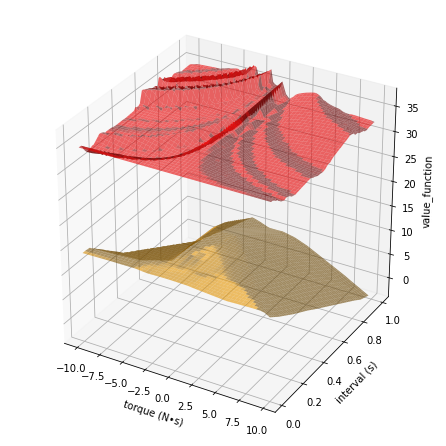

In [106]:
%matplotlib inline
#%matplotlib notebook


fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('torque (N•s)')
ax.set_ylabel('interval (s)')
ax.set_zlabel('value_function')

ax.plot_surface(A, T, const_state_Q_recurrence, alpha=0.6, label='recurrence_formula', color='red')
#ax.plot_surface(A, T, const_state_Q_supervised, alpha=0.6, label='supervised_critic_dist', color='cyan')
#ax.plot_surface(A, T, comparison, alpha=0.6, label='supervised_critic_episodic', color='magenta')
ax.plot_surface(A, T, const_state_Q, alpha=0.6, label='RL_learned_critic', color='orange')
#plt.legend()

In [99]:
action = np.arange(-10., 10., 0.2)            # x軸を作成
tau = np.arange(0.01, 1., 0.0099)            # y軸を作成
A, T = np.meshgrid(action, tau)             # x軸とy軸からグリッドデータを作成

const_state_Q = []
const_state_Q_recurrence = []

const_state = np.array([0.0, 0.0])
a.critic.load_weights('./saved_agent/learned_self_clipped4_critic.h5')
for ac, t in zip(A.flatten(), T.flatten()):
    action = np.array([ac, t])
    const_state_Q.append(value_for_one_state(action, a, const_state))

a.critic.load_weights('./saved_agent/learned_self_clipped4_critic_supervised.h5')
for ac, t in zip(A.flatten(), T.flatten()):
    action = np.array([ac, t])
    const_state_Q_recurrence.append(learned_Q(const_state, action, a, env))


const_state_Q, const_state_Q_recurrence = np.array(const_state_Q).reshape(100, 100), np.array(const_state_Q_recurrence).reshape(100, 100)

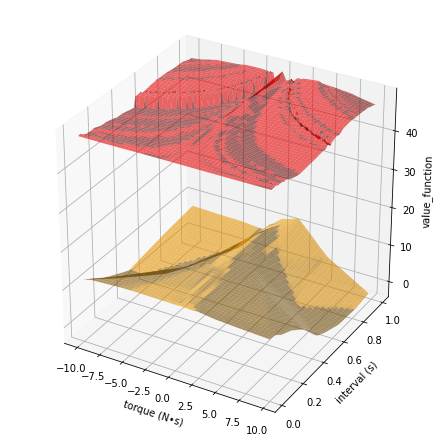

In [100]:
%matplotlib inline
#%matplotlib notebook


fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('torque (N•s)')
ax.set_ylabel('interval (s)')
ax.set_zlabel('value_function')

ax.plot_surface(A, T, const_state_Q, alpha=0.6, color='orange')
ax.plot_surface(A, T, const_state_Q_recurrence, alpha=0.6, label='recurrence_formula', color='red')

#plt.legend()

In [8]:
action = np.arange(-10., 10., 0.2)            # x軸を作成
tau = np.arange(0.01, 1., 0.0099)            # y軸を作成
A, T = np.meshgrid(action, tau)             # x軸とy軸からグリッドデータを作成

const_state_Q = []
const_state_Q_recurrence = []

const_state = np.array([0.0, 0.0])

a.actor.load_weights('./saved_agent/learned_self_noisy_actor.h5')

a.critic.load_weights('./saved_agent/learned_self_noisy_critic.h5')
for ac, t in zip(A.flatten(), T.flatten()):
    action = np.array([ac, t])
    const_state_Q.append(value_for_one_state(action, a, const_state))

a.critic.load_weights('./saved_agent/learned_self_noisy_critic_supervised.h5')
for ac, t in zip(A.flatten(), T.flatten()):
    action = np.array([ac, t])
    const_state_Q_recurrence.append(learned_Q_noisy(const_state, action, a, env))


const_state_Q, const_state_Q_recurrence = np.array(const_state_Q).reshape(100, 100), np.array(const_state_Q_recurrence).reshape(100, 100)

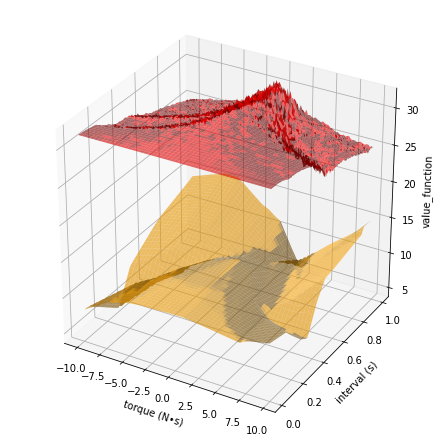

In [9]:
%matplotlib inline
#%matplotlib notebook


fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('torque (N•s)')
ax.set_ylabel('interval (s)')
ax.set_zlabel('value_function')

ax.plot_surface(A, T, const_state_Q, alpha=0.6, color='orange')
ax.plot_surface(A, T, const_state_Q_recurrence, alpha=0.6, label='recurrence_formula', color='red')

#plt.legend()

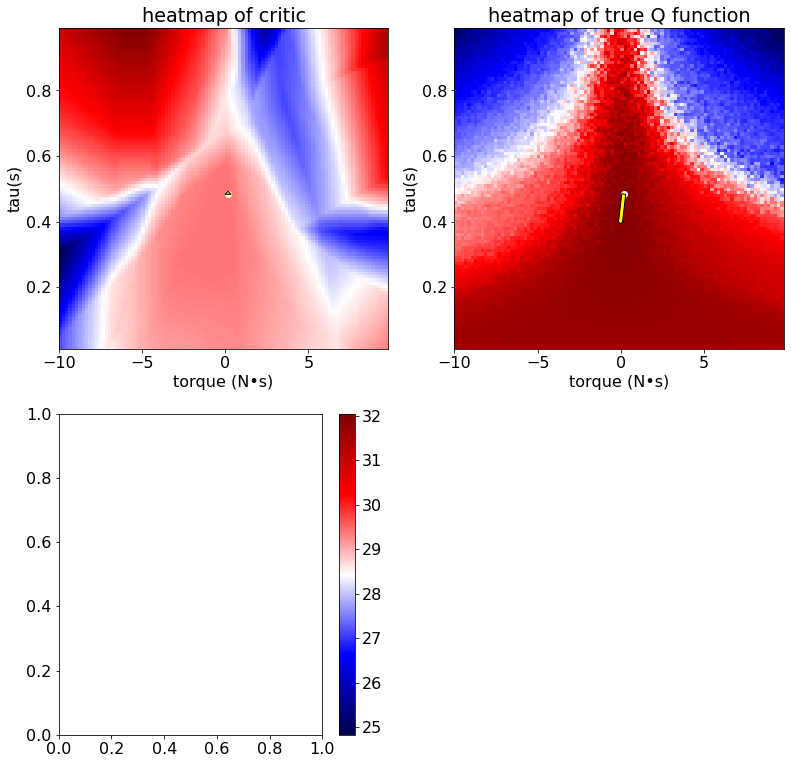

In [11]:
# heat map
action = a.actor.predict(np.array([[[0.0,0.0]]]))[0]
plt.figure(figsize=(13,13))
plt.rcParams["font.size"] = 16
ax1 = plt.subplot(221)
im1 = ax1.pcolormesh(A, T, const_state_Q, cmap='seismic')
ax1.scatter([action[0]], [action[1]], color='honeydew')
am, tm = np.gradient(const_state_Q ,.2, .2)
am, tm = am[48,50], tm[48,50]
ax1.annotate('',
        xy=(action[0]+am, action[1]+tm), xycoords='data',
        xytext=(action[0], action[1]), textcoords='data', fontsize=0,
        arrowprops=dict(shrink=100,width=4,headwidth=6,headlength=3,
                        connectionstyle='arc3',facecolor='yellow',edgecolor='black'))

ax1.set_xlabel('torque (N•s)')
ax1.set_ylabel('tau(s)')
ax1.set_title('heatmap of critic')
ax2 = plt.subplot(222)
im2 = ax2.pcolormesh(A, T, const_state_Q_recurrence,cmap='seismic')

ax2.scatter([action[0]], [action[1]], color='honeydew')
am, tm = np.gradient(const_state_Q_recurrence ,.2, .2)
am, tm = am[48,50], tm[48,50]
ax2.annotate('',
        xy=(action[0]+am, action[1]+tm), xycoords='data',
        xytext=(action[0], action[1]), textcoords='data', fontsize=0,
        arrowprops=dict(shrink=10,width=4,headwidth=6,headlength=3,
                        connectionstyle='arc3',facecolor='yellow',edgecolor='black'))
ax2.set_xlabel('torque (N•s)')
ax2.set_ylabel('tau(s)')
ax2.set_title('heatmap of true Q function')
ax3 = plt.subplot(223)

plt.colorbar(im2)


In [45]:
def learned_Q_noisy(state, action, agent, env, n_expectation_samples=10):
    # r(s,a) + gamma*V(s')
    
    l=1.
    average_reward = 0
    average_value = 0
    gamma = 0.99
    a_agent, tau = action
    print(action)
    action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.05
    dt = tau / action_repetition
    for i in range(n_expectation_samples):
        reward = 0
        env.reset()
        env.set_state(state)
        for p in range(action_repetition):
            _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
            reward += r
        reward *= dt
        reward += - tau * 0.01 * a_agent**2 + l * tau # step reward
        average_reward += reward / n_expectation_samples
    
        next_state = env.state
        print(next_state)
        next_value = value_function_ap(next_state, agent) # 学習できていないstateに行った時は間違ったvalueになるはず
        average_value += next_value / n_expectation_samples
    
    return average_reward + gamma * average_value

print(learned_Q_noisy(const_state,np.array([0.,1.]),a,env))
print(learned_Q(const_state,np.array([0.,1.]),a,env))

[0. 1.]
[-2.32116397 -6.28318531]
[ 0.12906219 -0.33686827]
[-2.96976619 -6.28318531]
[-2.28772203 -5.7501934 ]
[ 1.85032307 -5.53514482]
[2.97195546 6.28318531]
[-2.23028605  5.89222798]
[-1.20856518 -4.21883448]
[3.12629694 6.28318531]
[ 2.9299725  -6.18097822]
29.808215417913587
32.66223510742188
